# Project Report: Peak Session Start Hour on MineCraft

## Introduction

### Background Information

This project is based on data collected from a MineCraft server, led by Frank Wood at a research group in UBC Computer Science. Data was collected by recording various actions of players, as they were aiming to enhance recruitment and ensure adequate resources according to demand. Hence, two CSV files were provided: 'sessions.csv' and 'players.csv'.

In order to tackle this project, concepts of data reading, wrangling, and visualization were applied, as well as K-nearest neighbor regression modeling. To begin any data analysis, the files must be converted from data (stored in a CSV file, Excel file, database, etc.) into tabular data that R can use for analysis. Following this, data wrangling may begin. Data wrangling is essential to data analysis, as it permits the usage of the information that the data represents. This usage can take the form of data visualization: where the information is represented in a visual, easy-to-interpret format. Visualizations answer questions clearly, and can convey information (ie: messages, summaries).

In this project, K-nearest neighbor regression was used. This type of model uses the values of neighbors to predict the value of the response variable, which is defined as the variable to predict. Specifically, the model predicts the value by averaging the values of K-number of the closest points from the training data. The benefits of this model include its simple and intuitive nature, as well as how it requires few assumptions and works well for non-linear relationships. It can be slow with lots of training data, and cannot predict beyond the range of the training data, but these will likely not be a problem for this project. To assess the model, it is evaluated by calculating RMSE and RMSPE, where RMSE stands for "Root Mean Squared Error" and is used for the training set of data while RMSPE is used for the testing data. Additional details will follow during the narration of the analysis below. 

### Question
**Broad Question:** What time windows are most likely to have large number of simultaneous players (to ensure that the number of licenses on hand is sufficiently large to accommodate all parallel players with high probability)? (Question 3)

**Specific Question:** Based on the `sessions` dataset, when is the peak hour (max) to start a gaming session on MineCraft?

### Data Description

The `sessions.csv` data set is a CSV file, and has 1535 rows of 5 columns of data (7675 observations), including: hashedEmail, start_time, end_time, original_start_time, and original_end_time. This file is a log of all the player gaming sessions on MineCraft, including start and end time, and linked to the players by their hashed email. All column names are standardized, except for hashedEmail, but the data is not tidy since there are multiple observations per row and could be pivoted to a longer format. A table detailing the variables is provided below - the data types are based on their perceived type.  

| Column Name | Final Data Type | Description |
|:------------|:---------:|:------------|
| hashedEmail | chr       | The hashed email of the player; a non-recognizable identifier for each session |
| start_time  | dttm       | The human readable start date and time of a session, in MM/DD/YYYY and 24-hour (HH:MM) format |
| end_time    | dttm       | The human readable end date and time of a session, in MM/DD/YYYY and 24-hour (HH:MM) format |
| original_start_time | dbl | The start time of the session, in seconds from Jan 1 1970, based how computers track time |
| original_end_time   | dbl | The end time of the session, in seconds from Jan 1 1970, based how computers track time |

## Methods & Results

### Preparation & Data Wrangling

First, the necessary packages were loaded into the project. This includes: tidyverse, tidymodels, repr, and janitor.

Following, the `sessions.csv` file was loaded with the `read_csv()` function. Since the column names were not in a clean format, the data set was passed through `clean_names()`, which ensured that all the column names were lower case and containing underscores instead of spaces. The data analysis will center around the start times of the sessions, so only the `start_time` column was kept initially. Next, the dates were separated with `separate()` into three columns: `start_date`, `start_hour`, and `start_min`. This was stored as `sessions`, and now shows the start date (DD/MM/YYYY format), start hour (24 hour), and start minute (out of 60), all as characters. It was previously noted that this data is not tidy, but the method in which it was selected through allowed it to become tidy without using pivot functions.

Finally, this data was simplified down to prepare for visualization and analysis. Only the start_hour was kept, and was turned into a numeric data type with `as.numeric` in the `map_df()` function, which applies the `as.numeric()` function to each column while creating a dataframe. this was stored as `sessions_hour` with one column, called `start_hour` as a `dbl`.

See below for R code

In [7]:
# load packages
library(tidyverse)
library(tidymodels)
library(repr)
library(janitor)

# wrangle and clean data
sessions <- read_csv('sessions.csv') |> 
    clean_names() |>
    select(start_time) |>
    separate(start_time, into = c('start_date', 'start_time'), sep = ' ') |>
    separate(start_time, c('start_hour', 'start_min'), ':')
head(sessions)

# put data in format used for analysis
sessions_hour <- sessions |>
    select(start_hour) |>
    map_df(as.numeric)
head(sessions_hour)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


start_date,start_hour,start_min
<chr>,<chr>,<chr>
30/06/2024,18,12
17/06/2024,23,33
25/07/2024,17,34
25/07/2024,03,22
25/05/2024,16,01
23/06/2024,15,08


start_hour
<dbl>
18
23
17
3
16
15


### Exploratory Visualization

To represent the data in a visual form, the `sessions_hour` data frame was made into a histogram (Fig 1.), with `start_hour` on the x axis, and its count of player sessions started on the y axis. In Fig 1., peak hours are in the early morning and late night, with a significant dip around noon. 

In addition, this relationship was stored in a tabular form, in an object called `new_sessions_count`, with the columns `start_hour` (dbl) and `player_count` (int).

See R code below. 

start_hour,player_count
<dbl>,<int>
0,128
1,79
2,152
3,131
4,151
5,88


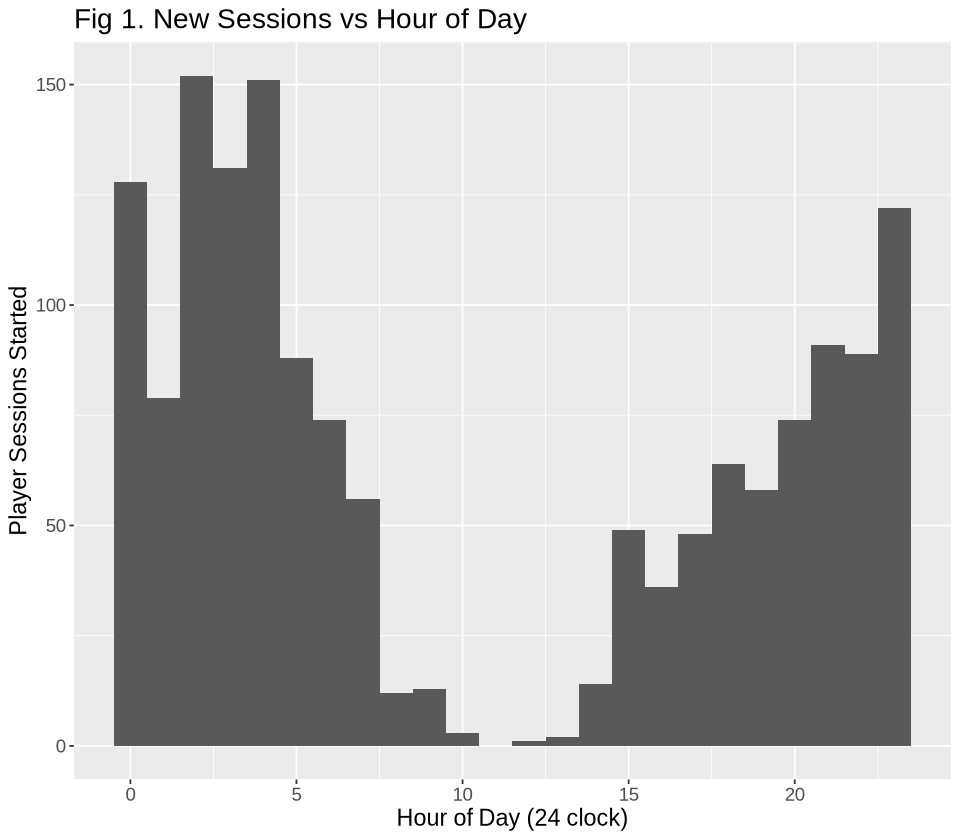

In [16]:
# visualization
options(repr.plot.width = 8, repr.plot.height = 7)

new_sessions_plot <- sessions_hour |>
    ggplot(aes(x = start_hour)) + 
    geom_histogram(binwidth = 1) + 
    labs(x = 'Hour of Day (24 clock)', y = 'Player Sessions Started', title = 'Fig 1. New Sessions vs Hour of Day') + 
    theme(text = element_text(size = 14))
new_sessions_plot

# tabular format
new_sessions_count <- sessions_hour |>
    group_by(start_hour) |>
    summarize(player_count = n()) 
head(new_sessions_count)

### Data Analysis: Choosing K for KNN Regression

For the predictive question stated above, a K-NN regression model was selected. This selection was chosen, as the question is using past information to predict future numerical variables. Since this is a K-nearest neighbour model, the response variable predictions will be based on similar observations (k-number of nearby ones). Assumptions made for this model were that all of the start times were collected in 24-hour format (so there are none in 12-hour format), and that each row of the data set represents a new session started. A potention limitation includes the cyclic nature of time (0 and 23 are adjacent, not on opposite ends). 

First, the data was split into training and testing sets, `sessions_training` and `sessions_testing` respectively, where the training set has 75% of the full set. To ensure reproducibility of the randomness of the split, `set.seed(200)` was used. Please note that for this step, and later for cross-validation, the `strata` arguments were removed, as there was not enough data. 

Second, cross-validation with 5 folds was used to choose K. This process began by specifying the model with `nearest_neighbor()`, stored in the `sessions_kspec` object, where 'kknn' and 'regression' were specified for the engine and mode of the model. A recipe was then created, stored as `sessions_recipe`, and specifying that `start_hour` was going to be used to predict `player_count`. The cross-validation object was created with `vfold_cv`, then everything was put together in a workflow. 
This workflow went on to collect the metrics of the model, where the neighbor generating the lowest RMSE value was selected. RMSE is the Root Mean Squared Error, and lower RMSE signifies smaller errors in predictions, thereby indicating a better performance. The best K value was found to be 2.

In [59]:
# Splitting of data
set.seed(200)
sessions_split <- initial_split(new_sessions_count, prop = 0.75) # removed: strata = player_count
sessions_training <- training(sessions_split)
sessions_testing <- testing(sessions_split)

# Choosing K
sessions_kspec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('regression')
sessions_recipe <- recipe(player_count ~ start_hour, data = sessions_training)

sessions_vfold <- vfold_cv(sessions_training, v = 5) # removed: strata = player_count
k_vals <- tibble(neighbors = seq(from = 1, to = 5, by = 1))

sessions_workflow <- workflow() |>
    add_model(sessions_kspec) |>
    add_recipe(sessions_recipe) |>
    tune_grid(resamples = sessions_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "rmse") 
    
k_min <- sessions_workflow |>
    slice_min(mean, n = 1) |> 
    select(neighbors) |>
    pull()
k_min

[1] 2

### Testing and Representing the Model

Once the K value was determined, another model was created with the specific value, and this was put into a workflow alongside the recipe and fititng of the training data, `sessions_training`. This was then used to predict the values of the test set, `sessions_testing`, by using `predict` and then `bind_cols` to essentially create an answer key.

This model was visualized as a scatter plot for the complete collection of true values, and as a blue line point for the prediction values. Note that the predictions do not encompass the entire range, simply due to the way the data was split. See Fig. 2., showing the `sessions_plot_pred` object. 

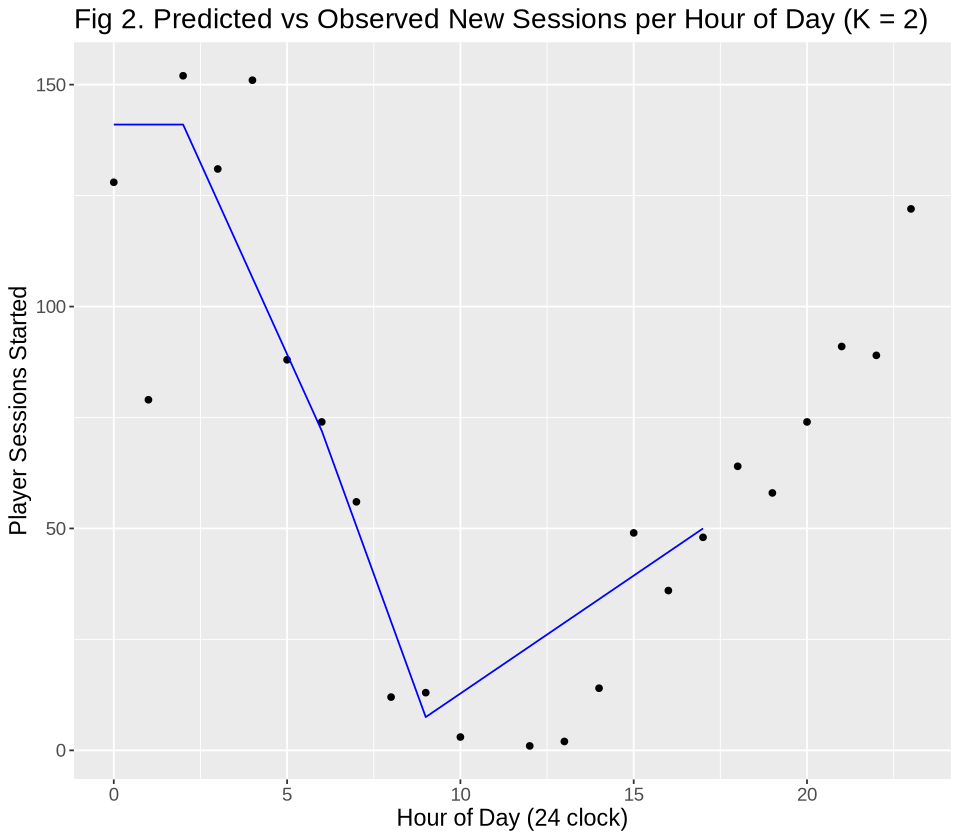

In [53]:
# KNN regression model
sessions_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = k_min) |>
    set_engine('kknn') |>
    set_mode('regression')

sessions_fit <- workflow() |>
    add_model(sessions_spec) |>
    add_recipe(sessions_recipe) |>
    fit(data = sessions_training)

sessions_predict <- sessions_fit |>
    predict(sessions_testing) |>
    bind_cols(sessions_testing)

# visualization
sessions_plot_pred <- new_sessions_count |>
    ggplot(aes(x = start_hour, y = player_count)) +
    geom_point() + geom_line(data = sessions_predict, aes(x = start_hour, y = .pred), color = 'blue') +
    labs(x = 'Hour of Day (24 clock)', y = 'Player Sessions Started', 
         title = 'Fig 2. Predicted vs Observed New Sessions per Hour of Day (K = 2)') + 
    theme(text = element_text(size = 14))
sessions_plot_pred

### Determination of Peak Hour and Evaluation of the Model

The peak hour of new sessions started was found to be 2am. This was determined visually in Fig 1., Fig 2., and verified by slicing the hour associated with the max value of sessions started.

To evaluate the model, the RMSE was extracted from the previous `sessions_workflow` object, and RMSPE calculated from the `sessions_predict` object, using `metrics()` and specifying the truth and estimate arguments. The main difference between RMSE and RMSPE is that RMSPE is the Root Mean Squared Error of the testing set, while the former is for the training set. If the values are similar, and a subjectively 'acceptable' value for the response variable, the model can generally be said to be good. In this case, RMSE is roughly 22 players and RMSPE 26 players. Given that the number of players can vary between 0 and 152 (as determined in the last chunk of code, using the `new_sessions_count` data frame with `start_time` and `player_count`, as well as the max and min functions), these values are pretty acceptable - especially considering the generally limited amount of data available. 

In [56]:
# Peak hour
sessions_max <- sessions_predict |>
    slice_max(player_count, n = 1) |>
    select(start_hour) |>
    pull()
sessions_max

[1] 2

In [57]:
# Evaluation by RMSE and RMPSE
rmse <- sessions_workflow |>
    slice_min(mean, n = 1) |> 
    select(mean) |>
    pull()
rmse

rmspe <- sessions_predict |>
    metrics(truth = player_count, estimate = .pred) |>
    filter(.metric == "rmse") |>
    select(.estimate) |>
    pull()
rmspe

[1] 21.95641

[1] 26.36996

In [58]:
# Determination of max and mins
min(new_sessions_count)
max(new_sessions_count)

[1] 0

[1] 152

## Discussion

### Summary of Findings

A K-nearest_neighbor regression model was built in order to predict which hour had the most new sessions started in MineCraft. K=2 was chosen for the regression model, which later found 2am to be the peak time of new sessions started (with 152 new sessions, based solely on the sessions data set). RMSE and RMSPE were calculated to evaluate the model's performance. 

### Reasonability, Improvements, and Impact

Overall, the results were expected and reasonable, notably when in comparison to the exploratory visualizations (which equally showed a max at 2am) and when comparing RMSE and RMSPE. However, the model could have been improved if the start times (including date) were treated differently. If the data was consolidated differently, there could have been more data points used for prediction, no need to remove `strata` arguments in splitting and cross-validation, and more to split between testing and training sets - this would have meant keeping the individual date labels while still counting based on the hour of the day.

The predictions obtained from this model could be used to guide when push notifications are sent out to players - ie: near or at the peak times. They can also be used to inform decisions regarding software licenses and server hardware, so that the peak amount of players starting games can be supported - especially since players are more likely to quit if the game starts up slow. 

### Future Investigations

Future investagations may include investigating why these hours are most popular although if contrained to the given data sets, which types of players play most at such peak starting hours and if this differs across experience levels or ages.

## References
Timbers, T.; Campbell, T; Lee, M.. (2024). Data Science: A First Introduction. UBC Department of Statistics.